In [1]:
from datetime import datetime

from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.visualization import hist

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [58]:
rootdir = Path("./data")
# use find to make this csv list
with open(rootdir / "reanalyze_csvs_2025.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [59]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,13254,1,binospec,13254
mmirs,4084,1,mmirs,4084


In [60]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
#fixed = fixed[fixed['time'] < "2020-12-31"]

In [61]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,xcen,ycen,seeing,raw_seeing,vlt_seeing,raw_vlt_seeing,ellipticity,fwhm,wavefront_rms,residual_rms
0,2025-01-03T02:53:34.022000,binospec,wfs_ff_cal_img_2025.01.03T025334.022.fits,30.0,1.2260,111.609118,54.655093,11.0,10.81,11.6,...,264.000240,244.012135,0.733352,0.828718,0.672919,0.760426,0.240052,4.908134,1096.497158,2186.287559
1,2025-01-03T02:54:07.177000,binospec,wfs_ff_cal_img_2025.01.03T025407.177.fits,30.0,1.2243,111.742606,54.764978,11.0,10.82,11.7,...,264.994151,244.980323,0.760592,0.858785,0.704796,0.795786,0.237833,5.025806,926.860215,2138.505707
2,2025-01-03T02:54:40.332000,binospec,wfs_ff_cal_img_2025.01.03T025440.332.fits,30.0,1.2226,111.879388,54.876911,11.0,10.75,11.6,...,262.998429,246.015478,0.769956,0.868634,0.709454,0.800378,0.173306,5.064349,642.785190,2201.209524
3,2025-01-03T02:55:13.596000,binospec,wfs_ff_cal_img_2025.01.03T025513.596.fits,30.0,1.2210,112.014357,54.986753,11.0,10.73,11.6,...,263.013863,245.985748,0.812936,0.916402,0.739424,0.833533,0.159270,5.251247,622.210254,2292.244811
4,2025-01-03T02:55:46.759000,binospec,wfs_ff_cal_img_2025.01.03T025546.759.fits,30.0,1.2193,112.150076,55.096649,11.0,10.76,11.6,...,264.988863,246.001222,0.661520,0.745091,0.614152,0.691739,0.251530,4.581114,480.324019,2096.353341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,2025-02-07T12:43:34.763000,binospec,wfs_ff_cal_img_2025.02.07T124334.763.fits,40.0,1.1297,-85.755499,62.271536,8.3,8.39,8.1,...,253.987486,249.988629,0.910092,0.979182,0.856727,0.921765,0.358959,5.496632,294.264408,1247.468680
711,2025-02-07T12:44:17.996000,binospec,wfs_ff_cal_img_2025.02.07T124417.996.fits,40.0,1.1313,-85.683658,62.124723,8.2,8.46,8.1,...,254.014387,250.016934,0.993854,1.070211,0.894945,0.963703,0.302897,5.851590,658.710220,1192.432145
712,2025-02-07T12:45:01.276000,binospec,wfs_ff_cal_img_2025.02.07T124501.276.fits,40.0,1.1328,-85.613792,61.981332,8.2,8.10,8.0,...,255.003816,250.020985,0.824119,0.888141,0.769394,0.829164,0.401536,5.140685,227.342241,1144.396514
713,2025-02-07T12:45:44.584000,binospec,wfs_ff_cal_img_2025.02.07T124544.584.fits,40.0,1.1343,-85.543207,61.835463,8.0,8.22,7.9,...,253.002310,249.994260,0.888802,0.958610,0.816162,0.880264,0.321609,5.416266,389.600843,1172.513178


In [62]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

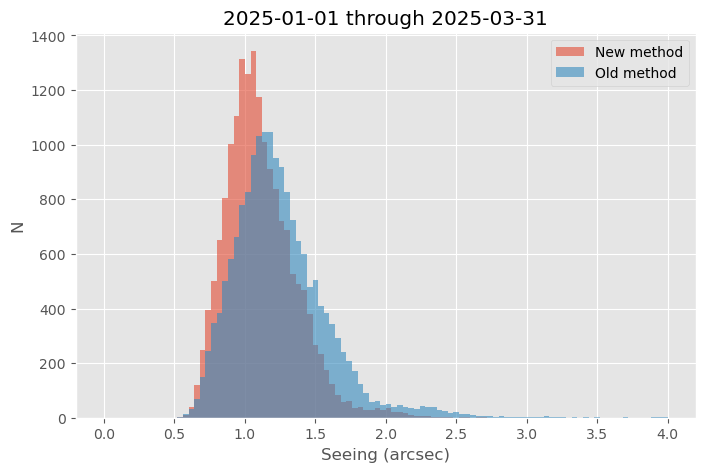

In [63]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
plt.hist(fixed['vlt_seeing'], bins=100, range=(0.0, 4.0), alpha=0.6, label="New method")
plt.hist(fixed['seeing'], bins=100, range=(0.0, 4.0), alpha=0.6, label="Old method")
with plt.style.context('ggplot'):
    plt.title("2025-01-01 through 2025-03-31")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.legend()
plt.show()

In [64]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['vlt_seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['vlt_seeing'])
fit_median = exp_mu + loc

0.29677486645268253 0.28436799626550097 0.7946354026439344


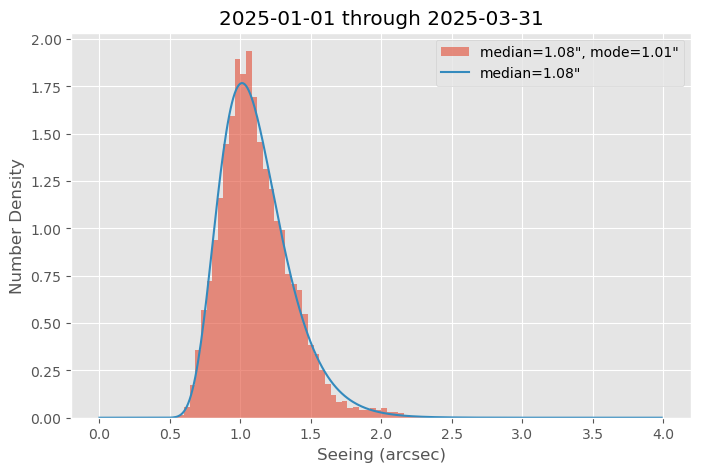

In [65]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['vlt_seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("2025-01-01 through 2025-03-31")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("2025_q1.png")
plt.show()

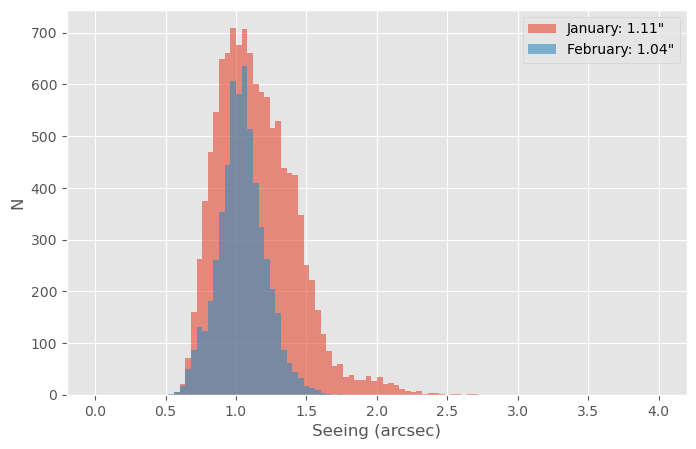

In [66]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months['January'] = fixed.loc['2025-01']
months['February'] = fixed.loc['2025-02']
#months['March'] = fixed.loc['2024-03']

for m in months:
    plt.hist(months[m]['vlt_seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]['vlt_seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2025_q1_monthly.png")
plt.show()

In [67]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['vlt_seeing'])
med_2nd = np.median(second_half['vlt_seeing'])

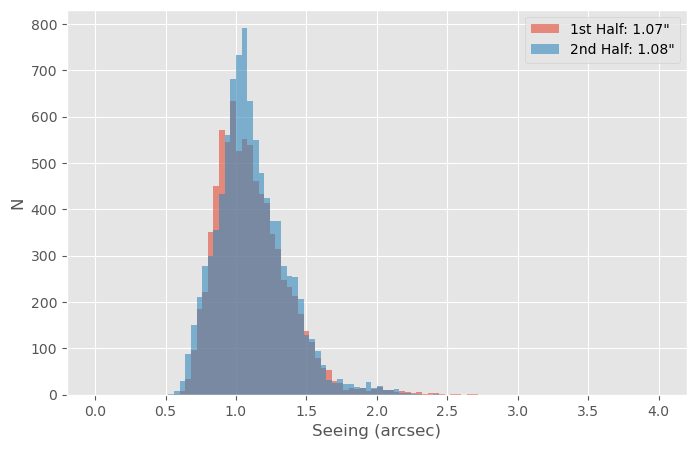

In [68]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2025_q1_1st2nd.png")
plt.show()

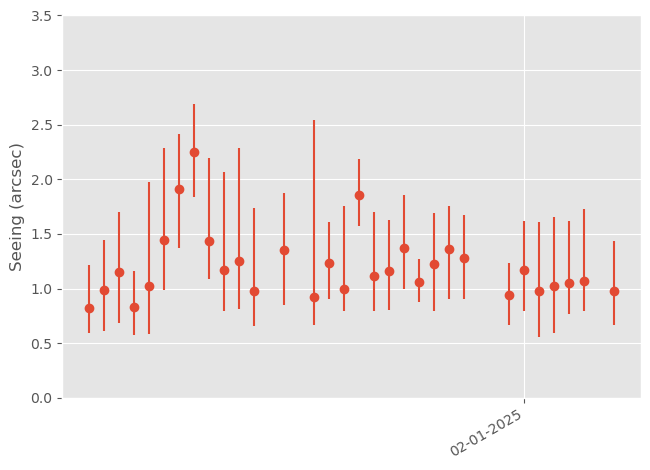

In [69]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.vlt_seeing.resample('D').median()
daily['max'] = fixed.vlt_seeing.resample('D').max()
daily['min'] = fixed.vlt_seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2025_q1_nightly.png")
plt.show()

In [70]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed.loc[date]['vlt_seeing']) for date in date_list]
clean_data = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

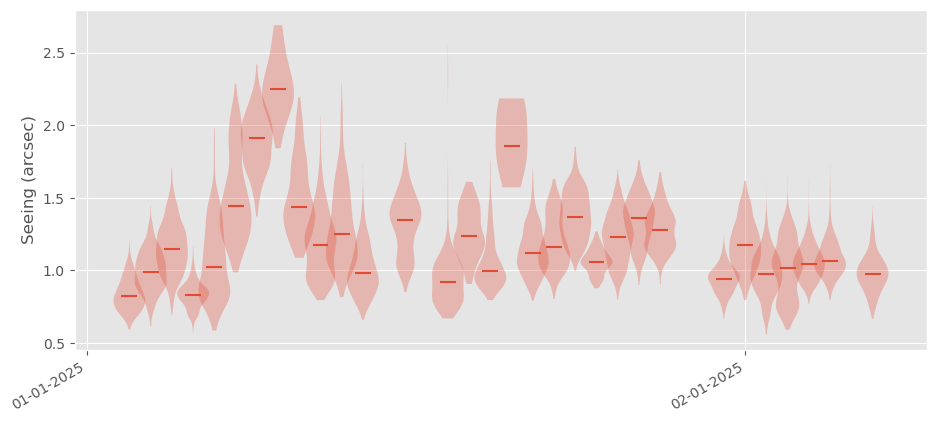

In [71]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2025_q1_violin.png")
    plt.show()

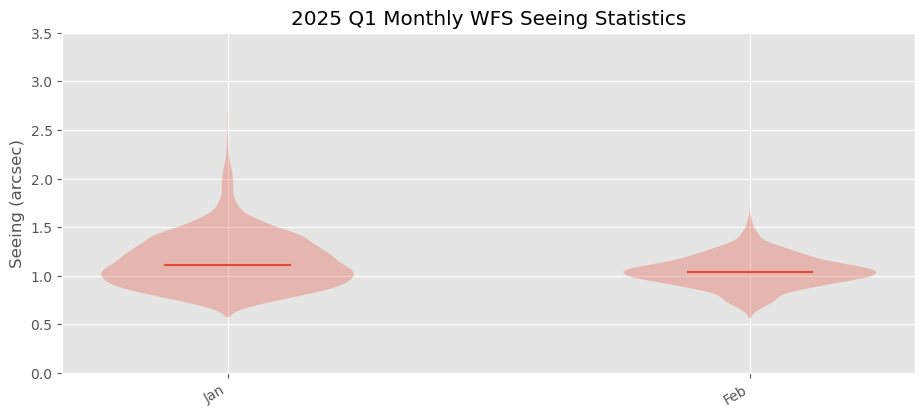

In [72]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(fixed.loc[month]['vlt_seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2025_q1_violin_monthly.png")
    plt.title("2025 Q1 Monthly WFS Seeing Statistics")
    plt.show()

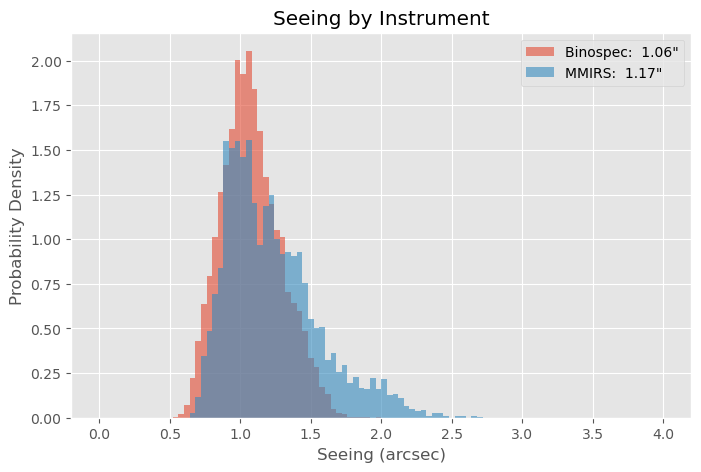

In [73]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'binospec'])
    #medf = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'f5'])
    medm = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'])
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'binospec'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Binospec: {medb: .2f}\"")
    #plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'f5'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Hecto: {medf: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
    plt.legend()
    plt.title("Seeing by Instrument")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Probability Density")
plt.savefig("per_instrument_2025_q1.png")
plt.show()

In [74]:
from minicyclop.io import read_seeing_data

In [88]:
cyclop = read_seeing_data(Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt")

In [89]:
cyclop

,UT,flux,seeing,r0,isot,epoch_ms
ut,,,,,,
2022-06-08 03:32:32,6/8/2022 3:32:32 AM,2733.7,0.84,135.8,2022-06-08T03:32:32.968,1654659152968
2022-06-08 03:33:27,6/8/2022 3:33:27 AM,2755.7,0.84,134.4,2022-06-08T03:33:27.409,1654659207408
2022-06-08 03:34:23,6/8/2022 3:34:23 AM,2801.6,2.38,47.7,2022-06-08T03:34:23.655,1654659263655
2022-06-08 03:35:16,6/8/2022 3:35:16 AM,2853.2,1.01,112.3,2022-06-08T03:35:16.325,1654659316324
2022-06-08 03:36:00,6/8/2022 3:36:00 AM,2739.0,1.03,110.7,2022-06-08T03:36:00.691,1654659360691
...,...,...,...,...,...,...
2025-02-08 06:37:28,2/8/2025 6:37:28 AM,1560.5,0.82,137.7,2025-02-08T06:37:28.007,1738996648007
2025-02-08 06:38:14,2/8/2025 6:38:14 AM,1484.8,0.62,183.9,2025-02-08T06:38:14.421,1738996694421
2025-02-08 06:39:00,2/8/2025 6:39:00 AM,1549.0,0.79,144.3,2025-02-08T06:39:00.913,1738996740912


In [90]:
cyclop_q1 = cyclop[(cyclop.index >= '2025-01-01') & (cyclop.index < '2025-04-01')]

0.6066351210374656 0.37615320371554634 0.7009267628035006


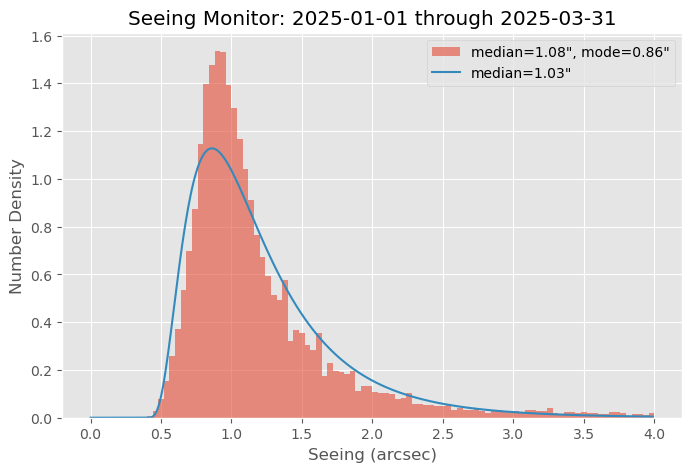

In [91]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(cyclop_q1['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(cyclop_q1['seeing'])
fit_median = exp_mu + loc

# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(cyclop_q1['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("Seeing Monitor: 2025-01-01 through 2025-03-31")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("2025_q1_cyclop_hist.png")
plt.show()

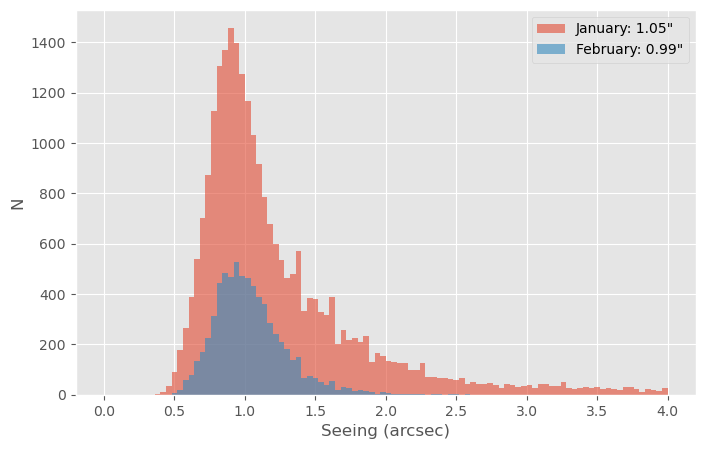

In [92]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
cyc_months = {}
legends = []
cyc_months['January'] = cyclop_q1.loc['2025-01']
cyc_months['February'] = cyclop_q1.loc['2025-02']
#cyc_months['March'] = cyclop_q1.loc['2024-03']

for m in cyc_months.keys():
    plt.hist(cyc_months[m]['seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(cyc_months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2025_q1_cyclop_monthly.png")
plt.show()

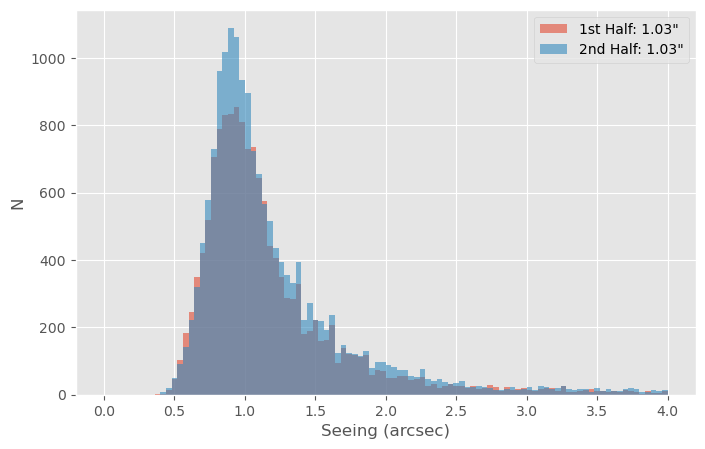

In [93]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = cyclop_q1.between_time(start_time='00:00', end_time='07:00')
second_half = cyclop_q1.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2025_q1_cyclop_1st2nd.png")
plt.show()

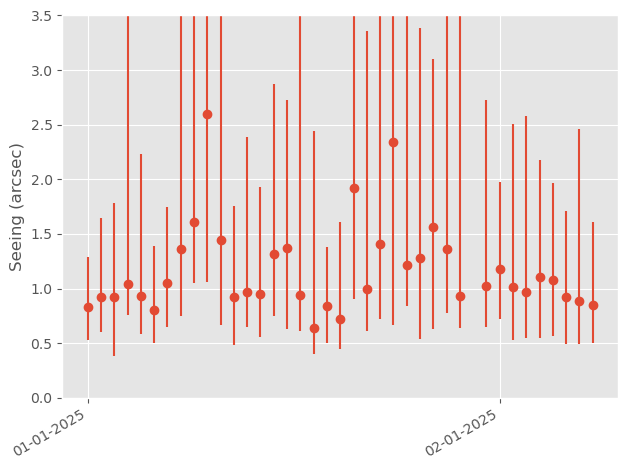

In [94]:
# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = cyclop_q1.seeing.resample('D').median()
daily['max'] = cyclop_q1.seeing.resample('D').max()
daily['min'] = cyclop_q1.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2025_q1_cyclop_plot_monthly.png")
plt.show()

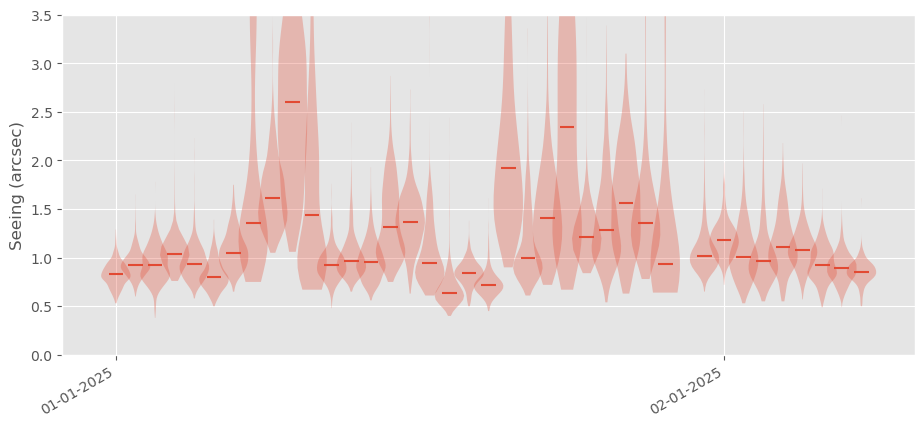

In [95]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(cyclop_q1.loc[date]['seeing']) for date in date_list]
clean_data = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2025_q1_cyclop_violin.png")
    plt.show()

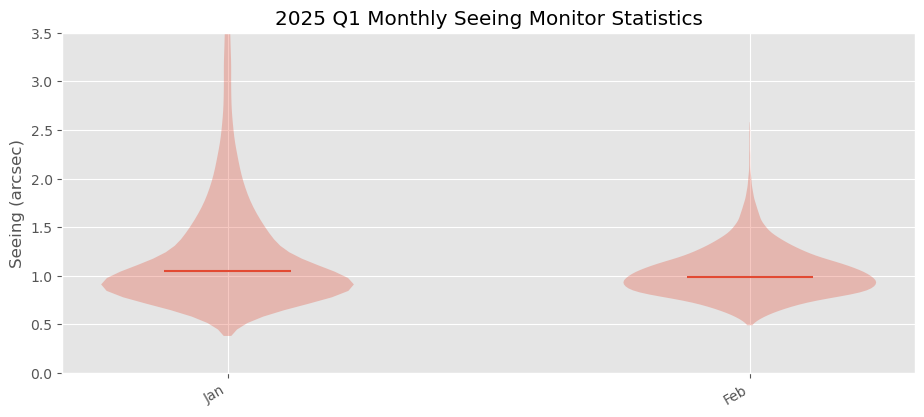

In [96]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(cyclop_q1.loc[month]['seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2025_q1_cyclop_violin_monthly.png")
    plt.title("2025 Q1 Monthly Seeing Monitor Statistics")
    plt.show()

In [97]:
bino = fixed[fixed['wfs'] == 'binospec']
#hecto = fixed[fixed['wfs'] == 'f5']
mmirs = fixed[fixed['wfs'] == 'mmirs']

In [98]:
bino_dates = sorted(list(set(bino.index.strftime('%Y-%m-%d'))))
#hecto_dates = sorted(list(set(hecto.index.strftime('%Y-%m-%d'))))
mmirs_dates = sorted(list(set(mmirs.index.strftime('%Y-%m-%d'))))
bino_dates, mmirs_dates

(['2025-01-03',
  '2025-01-04',
  '2025-01-05',
  '2025-01-06',
  '2025-01-07',
  '2025-01-22',
  '2025-01-23',
  '2025-01-24',
  '2025-01-25',
  '2025-01-26',
  '2025-01-27',
  '2025-01-28',
  '2025-01-31',
  '2025-02-01',
  '2025-02-02',
  '2025-02-03',
  '2025-02-04',
  '2025-02-05',
  '2025-02-07'],
 ['2025-01-08',
  '2025-01-09',
  '2025-01-10',
  '2025-01-11',
  '2025-01-12',
  '2025-01-13',
  '2025-01-14',
  '2025-01-16',
  '2025-01-18',
  '2025-01-19',
  '2025-01-20',
  '2025-01-21'])

In [99]:
cyc_bino = np.hstack([np.array(cyclop_q1.loc[date]['seeing']) for date in bino_dates])
#cyc_hecto = np.hstack([np.array(cyclop_q1.loc[date]['seeing']) for date in hecto_dates])
cyc_mmirs = np.hstack([np.array(cyclop_q1.loc[date]['seeing']) for date in mmirs_dates])

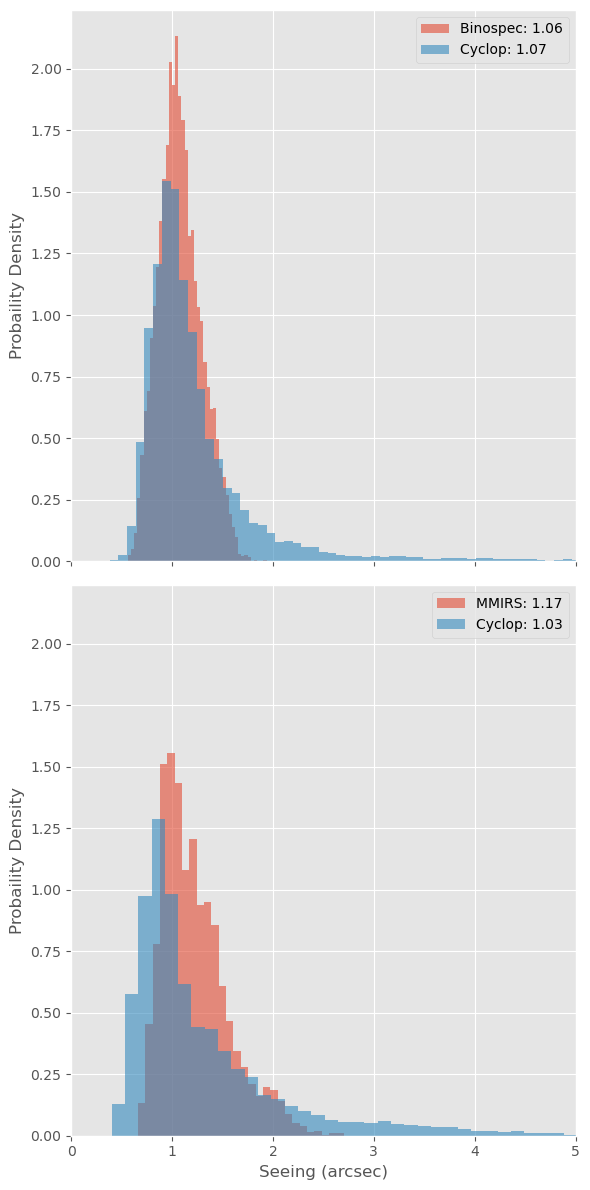

In [100]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(2, 1, figsize=(6, 12), sharex=True, sharey=True)
    ax = ax.flat
    fig.subplots_adjust(hspace=0)

    hist(bino['vlt_seeing'], bins='scott', ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_bino, bins='scott', ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    ax[0].legend([f"Binospec: {np.median(bino['vlt_seeing']):.2f}", f"Cyclop: {np.median(cyc_bino):.2f}"])
    ax[0].set_ylabel("Probaility Density")
    ax[0].set_xlim(0, 5)

    #hist(hecto['seeing'], bins='scott', ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    #hist(cyc_hecto, bins='scott', ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    #ax[1].legend([f"Hecto: {np.median(hecto['seeing']):.2f}", f"Cyclop: {np.median(cyc_hecto):.2f}"])
    #ax[1].set_ylabel("Probaility Density")
    #ax[1].set_xlim(0, 5)

    hist(mmirs['vlt_seeing'], bins='scott', ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_mmirs, bins='scott', ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    ax[1].legend([f"MMIRS: {np.median(mmirs['vlt_seeing']):.2f}", f"Cyclop: {np.median(cyc_mmirs):.2f}"])
    ax[1].set_xlim(0, 5)
    ax[1].set_xlabel("Seeing (arcsec)")
    ax[1].set_ylabel("Probaility Density")

    plt.tight_layout()
    plt.savefig("2025_q1_cyclop_vs_inst.png")
    plt.show()

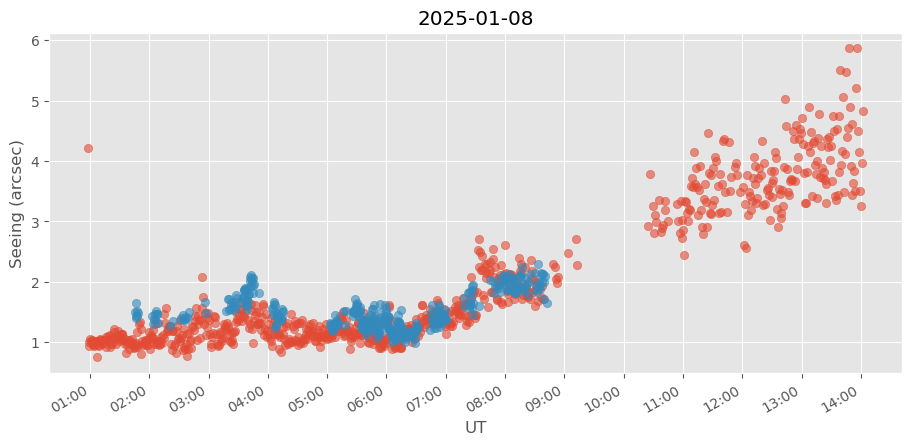

<Figure size 640x480 with 0 Axes>

In [101]:
date = '2025-01-08'
night = cyclop_q1.loc[date]
wfs_night = fixed.loc[date]
fig, ax = plt.subplots(figsize=(11,5))
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
fig.autofmt_xdate()
plt.scatter(night.index, night['seeing'], label="Seeing Monitor", alpha=0.6)
plt.scatter(wfs_night.index, wfs_night['vlt_seeing'], label="WFS", alpha=0.6)
plt.ylabel("Seeing (arcsec)")
plt.title(date)
plt.xlabel("UT")
plt.show()
plt.savefig("2025_01_08.png")

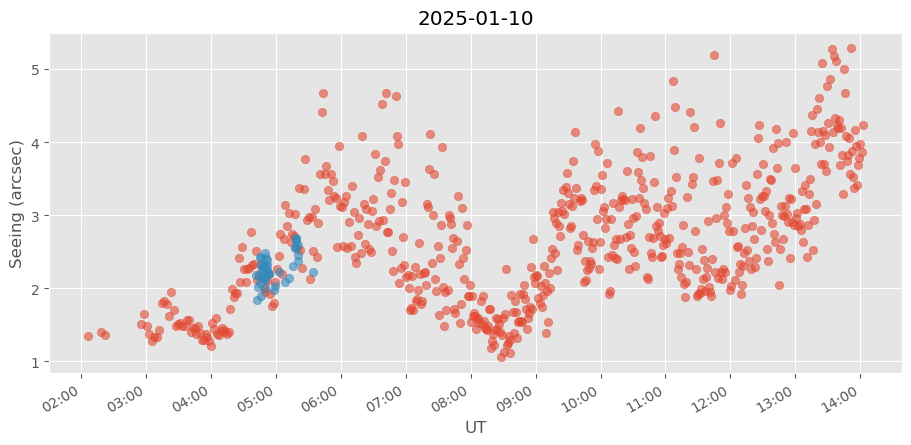

In [102]:
date = '2025-01-10'
night = cyclop_q1.loc[date]
wfs_night = fixed.loc[date]
fig, ax = plt.subplots(figsize=(11,5))
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
fig.autofmt_xdate()
plt.scatter(night.index, night['seeing'], label="Seeing Monitor", alpha=0.6)
plt.scatter(wfs_night.index, wfs_night['vlt_seeing'], label="WFS", alpha=0.6)
plt.ylabel("Seeing (arcsec)")
plt.title(date)
plt.xlabel("UT")
plt.show()

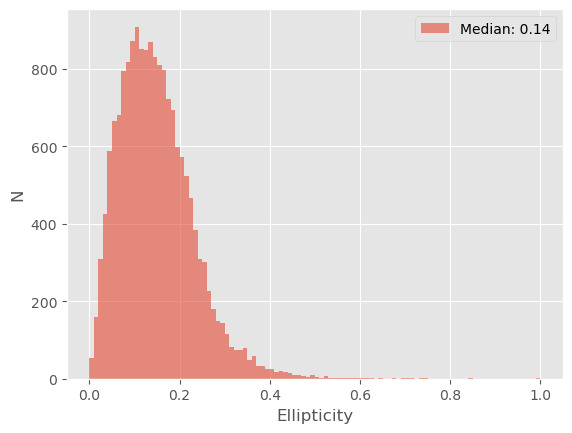

<Figure size 640x480 with 0 Axes>

In [103]:
plt.hist(fixed['ellipticity'], bins=100, range=(0.0, 1.0), alpha=0.6, label=f"Median: {np.median(fixed['ellipticity']):.2f}")
plt.xlabel("Ellipticity")
plt.ylabel("N")
plt.legend()
plt.show()
plt.savefig("ellipticity_2025_q1.png")